# Pre-set

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

# Problem 1

## Lagrange interpolation

In [3]:
points = np.linspace(-1,1,21)

In [4]:
def runge(x):
    return 1/(1+25*x**2)

In [5]:
def lagrange(x,pts,func):
    pts_lens = pts.shape[0]
    output = 0
    for i in range(pts_lens):
        temp = 1
        for j in range(pts_lens):
            if (i==j):
                continue
            else:
                temp*=(x-pts[j])/(pts[i]-pts[j])
        output+=temp*func(pts[i])
    return output

def lagrange_array(x,pts,func):
    output = [lagrange(i,pts,func) for i in x]
    return np.asarray(output)

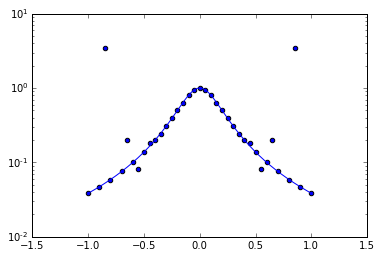

In [6]:
xmid = np.linspace(-1,1,41)
xs = np.linspace(-1,1,1000+1)
plt.figure()
plt.semilogy(xs,runge(xs))
ys = lagrange_array(xmid,points,runge)
plt.scatter(xmid,ys)

## Chebyshev interpolation

In [7]:
def Tn(x,n):
    return np.cos(n*np.arccos(x))

In [8]:
def c_N_m(N,m,func):
    factor = 2 / N
    if m==0:
        factor/=2
    output = 0
    for i in range(N):
        output += np.cos(m*np.pi*(i+0.5)/N)*func(np.cos(np.pi*(i+0.5)/N))
    return output*factor

def Che(x,N,func):
    output = 0
    for i in range(N):
        output+=Tn(x,i)*c_N_m(N,i,func)
    return output

def Che_array(xs,N,func):
    output = [Che(i,N,func) for i in xs]
    return np.asarray(output)

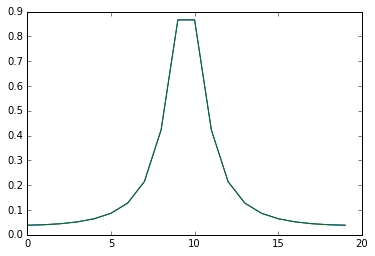

In [9]:
x_che = np.cos(np.pi*(np.arange(0,20)+1/2)/20)
plt.figure()
plt.plot(runge(x_che))
plt.plot(Che_array(x_che,20,runge))

## Cubic Spline interpolation
### with period/nature boundary condition

In [10]:
def Thomas_solver(a,b,c,n,d):
    beta = [c[0]/b[0]]
    for i in range(n-2):
        beta.append(c[i+1]/(b[i+1]-a[i]*beta[i]))
    y = [d[0]/b[0]]
    for i in range(n-1):
        y.append((d[i+1]-a[i]*y[i])/(b[i+1]-a[i]*beta[i]))
    for i in range(n-1):
        y[n-i-2] -= beta[n-i-2]*y[n-i-1]
    return np.asarray(y)

In [11]:
def cubic_sp_M(ptsx, ptsy,bctype = 0):#bctype = 0: period BC, bctype = 1: natural BC
    # common set up
    h = [ptsx[i+1] - ptsx[i] for i in range(len(ptsx)-1)]
    mu = [h[i]/(h[i]+h[i+1]) for i in range(len(h)-1)]
    lam = [h[i+1]/(h[i]+h[i+1]) for i in range(len(h)-1)]
    d = [6*(ptsy[i]/h[i]/(h[i]+h[i+1])+ptsy[i+2]/h[i+1]/(h[i]+h[i+1])-ptsy[i+1]/h[i]/h[i+1]) for i in range(len(h)-1)]
    # set up to different BC
    if (bctype == 0):
        d += [6*((ptsy[1]-ptsy[0])/h[0]-(ptsy[-1]-ptsy[-2])/h[-1])/(h[-1]+h[0])]
        mu += [h[-1]/(h[0]+h[-1])]
        lam += [h[0]/(h[0]+h[-1])]

        mu2lamn = [-mu[1]]+[0 for i in range(len(h)-1-2)]+[-lam[-1]]
        diag = [2 for i in range(len(h)-1)]
        M1 = Thomas_solver(mu[2:],diag,lam[1:-1],len(diag),d[1:])
        M2 = Thomas_solver(mu[2:],diag,lam[1:-1],len(diag),mu2lamn)

        M = [(d[0]-lam[0]*M1[0]-mu[0]*M1[-1])/(2+lam[0]*M2[0]+mu[0]*M2[-1])]
        M += [i for i in (M1+M[0]*M2)]
        M = [M[-1]] + M
        return np.asarray(M), np.asarray(h)
    else:
        d = [0] + d + [0]
        lam = [0] + lam
        mu = mu + [0]
        diag = [2 for i in range(len(h)+1)]
        return Thomas_solver(mu,diag,lam,len(diag),d),np.asarray(h)

In [12]:
cubic_sp_M(points,runge(points),bctype=1)

(array([  0.        ,   0.36154331,   0.45427926,   0.75141735,
          1.26813126,   2.21769719,   4.34383862,   7.78095365,
         15.30157757,  -4.37187931, -57.81406035,  -4.37187931,
         15.30157757,   7.78095365,   4.34383862,   2.21769719,
          1.26813126,   0.75141735,   0.45427926,   0.36154331,
          0.        ]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

In [13]:
def cubic_sp_plot(ptsx,ptsy,bctype = 0,ifplot = True,number=20):
    M,h = cubic_sp_M(ptsx,ptsy,bctype)
    x = np.asarray([])
    y = np.asarray([])
    for i in range(len(ptsy)-1):
        if(i==0):
            xs = np.linspace(ptsx[i],ptsx[i+1],number+1)
        else:
            xs = np.linspace(ptsx[i],ptsx[i+1],number+1)[1:]
        ys = M[i]/6/h[i]*np.power(ptsx[i+1]-xs,3)+M[i+1]/6/h[i]*np.power(xs-ptsx[i],3)+(ptsy[i]-M[i]*h[i]**2/6)*(ptsx[i+1]-xs)/h[i]+(ptsy[i+1]-M[i+1]*h[i]**2/6)*(xs-ptsx[i])/h[i]
        x = np.concatenate((x,xs))
        y = np.concatenate((y,ys))
    if(ifplot):
        plt.figure()
        plt.plot(x,y)
    return x,y

In [14]:
def cubic_sp_points(ptsx,ptsy,bctype=0):
    M,h = cubic_sp_M(ptsx,ptsy,bctype)
    x = np.asarray([])
    y = np.asarray([])
    for i in range(len(ptsy)-1):
        x_mid = (ptsx[i]+ptsx[i+1])/2
        if (i == 0):
            xs = np.asarray([ptsx[i],x_mid,ptsx[i+1]])
        else:
            xs = np.asarray([x_mid,ptsx[i+1]])
        ys = M[i]/6/h[i]*np.power(ptsx[i+1]-xs,3)+M[i+1]/6/h[i]*np.power(xs-ptsx[i],3)+(ptsy[i]-M[i]*h[i]**2/6)*(ptsx[i+1]-xs)/h[i]+(ptsy[i+1]-M[i+1]*h[i]**2/6)*(xs-ptsx[i])/h[i]
        x = np.concatenate((x,xs))
        y =np.concatenate((y,ys))
    return x,y

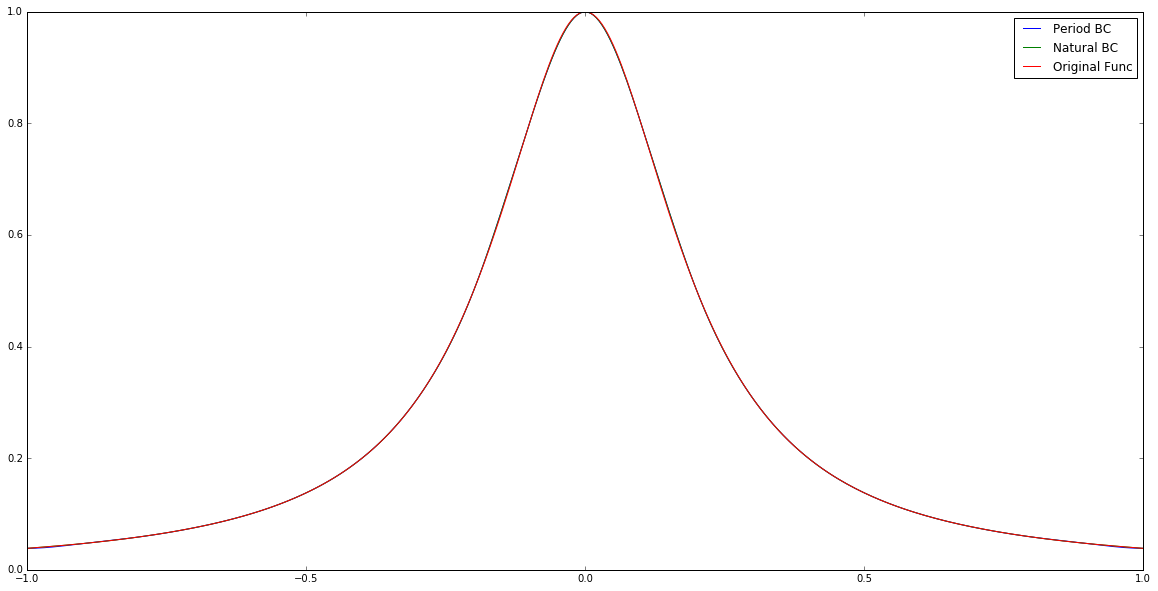

In [15]:
x_per,y_per = cubic_sp_plot(points,runge(points),ifplot=False)
x_nat,y_nat = cubic_sp_plot(points,runge(points),bctype=1,ifplot=False)
plt.figure(figsize=(20,10))
plt.plot(x_per,y_per,label='Period BC')
plt.plot(x_per,y_nat,label='Natural BC')
plt.plot(x_per,runge(x_per),label='Original Func')
plt.legend()

# Problem 2

## construct coordinates

In [92]:
def r(phi):
    return 1-np.cos(phi)

In [93]:
t = np.arange(0,9)
print(t)
phi= np.pi/4*t
rt = [r(i) for i in phi]
xt = [rt[i]*np.cos(phi[i]) for i in t]
yt = [rt[i]*np.sin(phi[i]) for i in t]

for i in range(9):
    print(xt[i],yt[i],t[i],rt[i])

[0 1 2 3 4 5 6 7 8]
0.0 0.0 0 0.0
0.20710678118654752 0.20710678118654746 1 0.2928932188134524
6.123233995736765e-17 0.9999999999999999 2 0.9999999999999999
-1.2071067811865475 1.2071067811865475 3 1.7071067811865475
-2.0 2.4492935982947064e-16 4 2.0
-1.207106781186548 -1.2071067811865475 5 1.7071067811865477
-1.8369701987210302e-16 -1.0000000000000002 6 1.0000000000000002
0.2071067811865476 -0.20710678118654768 7 0.29289321881345265
0.0 -0.0 8 0.0


## get Ms for cubic spline

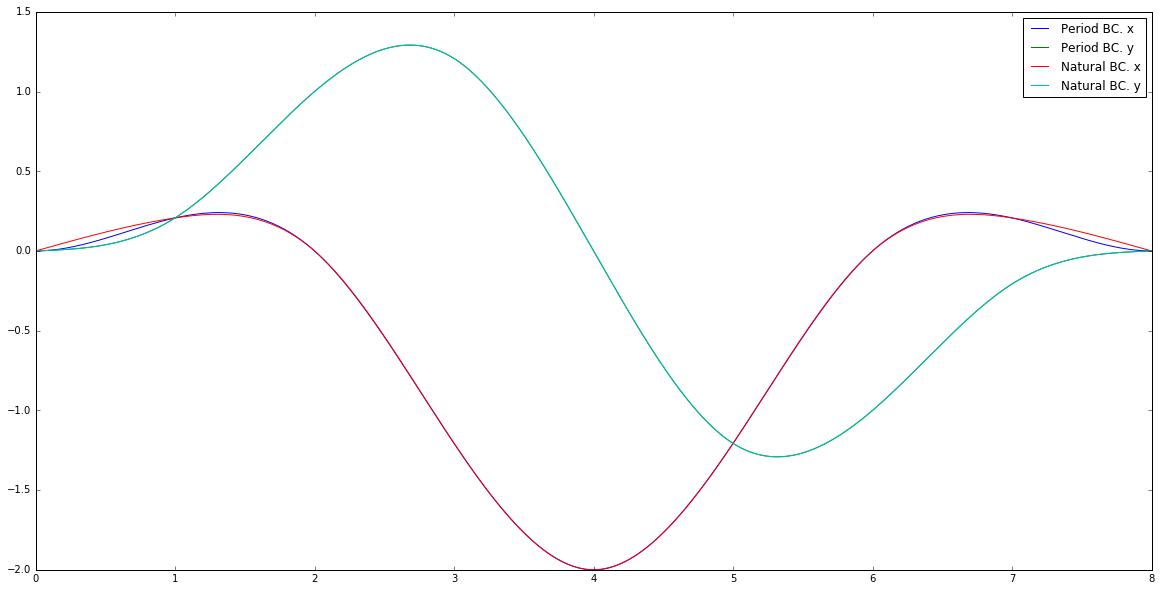

In [95]:
Mx,hx = cubic_sp_M(t,xt)
My,hy = cubic_sp_M(t,yt)

t_sp1,x_sp = cubic_sp_plot(t,xt,bctype=0,ifplot=False,number=100)
t_sp2,y_sp = cubic_sp_plot(t,yt,bctype=0,ifplot=False,number=100)


t_sp3,x_sp1 = cubic_sp_plot(t,xt,bctype=1,ifplot=False,number=100)
t_sp4,y_sp1 = cubic_sp_plot(t,yt,bctype=1,ifplot=False,number=100)


plt.figure(figsize=(20,10))
plt.plot(t_sp1,x_sp,label='Period BC. x')
plt.plot(t_sp2,y_sp,label='Period BC. y')
plt.plot(t_sp3,x_sp1,label='Natural BC. x')
plt.plot(t_sp4,y_sp1,label='Natural BC. y')
plt.legend()

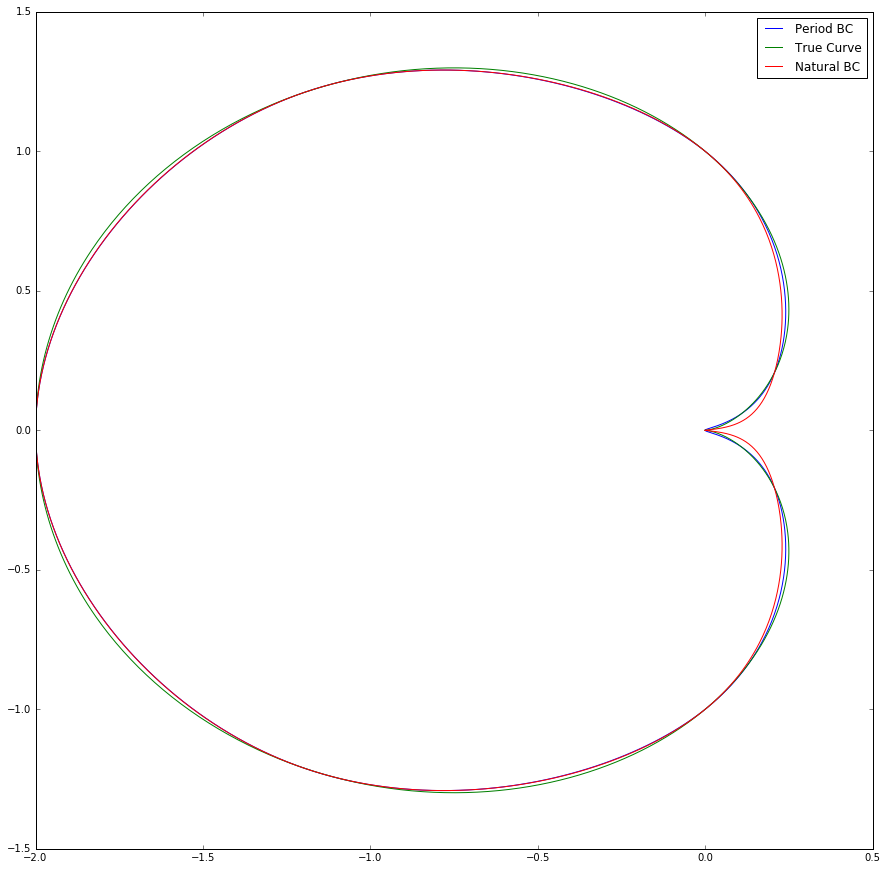

In [99]:
plt.figure(figsize=(15,15))
plt.plot(x_sp,y_sp,label='Period BC')
t_real = np.linspace(0,2*np.pi,1000+1)
x_real = [r(i)*np.cos(i) for i in t_real]
y_real = [r(i)*np.sin(i) for i in t_real]
plt.plot(x_real,y_real,label='True Curve')
plt.plot(x_sp1,y_sp1,label='Natural BC')
plt.legend()

# Problem 3

## Series Trunctuation

In [21]:
B_k = [1, -(1/2), 1/6, 0, -(1/30), 0, 1/42, 0, -(1/30), 0, 5/66]

In [63]:
def Tjk(j,k,h,T0=None):
    if k != 0:
        return Tjk(j,k-1,h,T0)+(Tjk(j,k-1,h,T0)-Tjk(j-1,k-1,h,T0))/(h[j-k]/h[j]-1)
    else:
        return T0[j]

def Romberg_int(f,nmax,start = 0, end = 1):
    T = []
    T0 = []
    h2 = []
    for i in range(nmax+1):
        h = np.linspace(start,end,2**i+1)
        tmp = np.asarray([f(hi) for hi in h]) * (end-start)/(2**i)
        tmp[0]/=2
        tmp[-1]/=2
        T0.append(tmp.sum())
        h2.append(((end-start)/(2**i))**2)
    T.append(T0)
    for i in np.arange(1,nmax+1):
        tmp = []
        for j in np.arange(i,nmax+1):
            tmp.append(Tjk(j,i,h2,T[0]))
        T.append(tmp)
    return T[-1][0]

For the second term:
$$
    \int_0^1 t^{-3/2}(\exp{(tq^2)}-1)dt\\
    =\int_0^1 t^{-3/2}\sum_{1}^{\infty}\frac{q^{2n}t^n}{n!} dt\\
    =\sum_{1}^{\infty}\frac{2 {q}^{2n}}{(2 n-1) n!}
$$
According to Stirling's approximation
$$
    n!\approx\sqrt{2\pi n}{(\frac{n}{e})}^n
$$
Every terms are $\sim \frac{(eq^2)^n}{n^{n+3/2}}$ when $n$ is very large.
So the series will converge, even $q^2\to3$, after $n>3e$, namely $n\geq9$, every term would be very small, we can neglect them then.

In [49]:
def fact(n):
    output = 1
    for i in range(n):
        output*=(1+i)
    return output
def term2(n,q2):
    return 2*q2**(n)/(2*n-1)/fact(n)

for i in range(15):
    print('n={:d}\t{:f}'.format((i+1),term3(i+1,3)))

n=1	6.000000
n=2	3.000000
n=3	1.800000
n=4	0.964286
n=5	0.450000
n=6	0.184091
n=7	0.066758
n=8	0.021696
n=9	0.006381
n=10	0.001713
n=11	0.000423
n=12	0.000096
n=13	0.000020
n=14	0.000004
n=15	0.000001


For the first term:
1. $q^2\to0,1,2$ are singular points, so we don't need to sum so many terms in those regions.
2. However, when $q^2$ is not close to the sigular points, we should analyse it carefully. Since $\mathbf{n}^2=0,1,2,3,4,5,6,8\cdots$, we can see the values of each terms correspond to certain $\mathbf{n}^2$ at $q^2=0.5,1.5,2.5$

In [52]:
def term1(n2,q2):
    return np.exp(q2-n2)/(n2-q2)

for n2 in range(16):
    if n2%8 == 7:
        continue
    print("{:d}\t{:f}\t{:f}\t{:f}".format(n2,term1(n2,0.5),term1(n2,1.5),term1(n2,2.5)))

0	-3.297443	-2.987793	-4.872998
1	1.213061	-3.297443	-2.987793
2	0.148753	1.213061	-3.297443
3	0.032834	0.148753	1.213061
4	0.008628	0.032834	0.148753
5	0.002469	0.008628	0.032834
6	0.000743	0.002469	0.008628
8	0.000074	0.000231	0.000743
9	0.000024	0.000074	0.000231
10	0.000008	0.000024	0.000074
11	0.000003	0.000008	0.000024
12	0.000001	0.000003	0.000008
13	0.000000	0.000001	0.000003
14	0.000000	0.000000	0.000001


For the third term:
Since:
$$
    \lim_{t\to0_+}t^{-3/2}\exp{(-(\pi^2/t)\mathbf{n}^2)}=0
$$
The integrated function doesn't have a singular point. So we can use numerical integration method to deal with it. But for the first step we can just calculate the kernel to have a 

In [201]:
def term3(x,n2,q2):
    if x == 0:
        return 0
    else:
        return x**(-3/2)*np.exp(x*q2)*np.exp(-np.pi**2*n2/x)
def term3_int(n2,q2):
    return Romberg_int(lambda x: term3(x,n2,q2),7)

for n2 in range(16):
    if n2%8 == 7 or n2==0:
        continue
    print("{:d}\t{}\t{}\t{}".format(n2,term3_int(n2,0.5),term3_int(n2,1.5),term3_int(n2,2.5)))

1	7.928688170120304e-06	1.9946214340157888e-05	5.0401110740735674e-05
2	2.1334536626978616e-10	5.552199543509317e-10	1.4472049648709305e-09
3	7.464485071095102e-15	1.9683304690605253e-14	5.194529750324127e-14
4	2.917689655944458e-19	7.74804267048365e-19	2.05853258410908e-18
5	1.2129302639540183e-23	3.2351368111647357e-23	8.631624731463427e-23
6	5.244545326470696e-28	1.403026348379083e-27	3.754279581850193e-27
8	1.0565202855871019e-36	2.83727065000204e-36	7.620512298810099e-36
9	4.864115056368086e-41	1.3079531012094953e-40	3.5174592875400236e-40
10	2.266840824160115e-45	6.101914502087849e-45	1.6426730638392678e-44
11	1.0669324380415746e-49	2.8744799427012824e-49	7.744887351810497e-49
12	5.06314814223769e-54	1.3650876426645207e-53	3.6806875545804795e-53
13	2.4194689332784366e-58	6.527270669979814e-58	1.7610344916503638e-57
14	1.1630794636840834e-62	3.1394732110640647e-62	8.474728605013664e-62


Note that it is easy to analyse them seperately, but if we sum them up, the minus term and plus term may cancelled with each other.

In [217]:
def zeta_00(q2,n2m1=5,n2m2=5,km=10):
    output = -np.pi
    for nx in range(4):
        for ny in range(4): 
            for nz in range(4):
                n2 = nx**2+ny**2+nz**2
                if (n2>n2m1):
                    continue
                else:
                    if n2!=0:
                        output+=term1(n2,q2)/np.sqrt(4*np.pi)
                    else:
                        output+=term1(n2,q2)/np.sqrt(4*np.pi)
    
    for i in range(km):
        output+=term2(i+1,q2)*np.pi/2
    
    for nx in range(4):
        for ny in range(4): 
            for nz in range(4):
                n2 = nx**2+ny**2+nz**2
                if (n2>n2m2 or n2 == 0):
                    continue
                else:
                    output+=term3_int(n2,q2)/np.sqrt(4*np.pi)*np.pi
    
    return output

In [218]:
x = np.linspace(0,1,100+1)[1:-1]
x = [x,x+1,x+2]
x = np.asarray(x).reshape(-1)

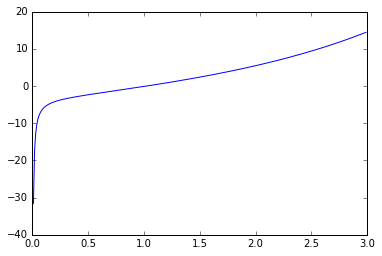

In [219]:
zeta00 = [zeta_00(i,0.1,1,7) for i in x]
plt.plot(x,zeta00)

## Root estimation

In [220]:
def secant(f,xm1=0.5,xm2=0.55,accuracy=1e-12):
    print(f(xm1),f(xm2))
    if np.abs(f(xm1)*(xm1-xm2)/(f(xm1)-f(xm2))) < accuracy:
        return xm1
    else:
         return secant(f,xm1-f(xm1)*(xm1-xm2)/(f(xm1)-f(xm2)),xm1,accuracy)

In [221]:
def f(x):
    return zeta_00(x,0,1,7) - np.pi**(3/2)*(1+x/4)
print(secant(f))

-8.620079724860025 -8.45897188346175
6.753059963015584 -8.620079724860025
-2.896641836379632 6.753059963015584
-0.7224445456109319 -2.896641836379632
0.11459439546908712 -0.7224445456109319
-0.003755083761769029 0.11459439546908712
-1.8742990951281513e-05 -0.003755083761769029
3.085034450123203e-09 -1.8742990951281513e-05
-7.105427357601002e-15 3.085034450123203e-09
2.454520449229298


In [222]:
print(secant(np.sin,3,4))

0.1411200080598672 -0.7568024953079282
-0.015569509788328599 0.1411200080598672
4.639800062679684e-05 -0.015569509788328599
-1.8691713617942337e-09 4.639800062679684e-05
1.2246467991473532e-16 -1.8691713617942337e-09
3.141592653589793


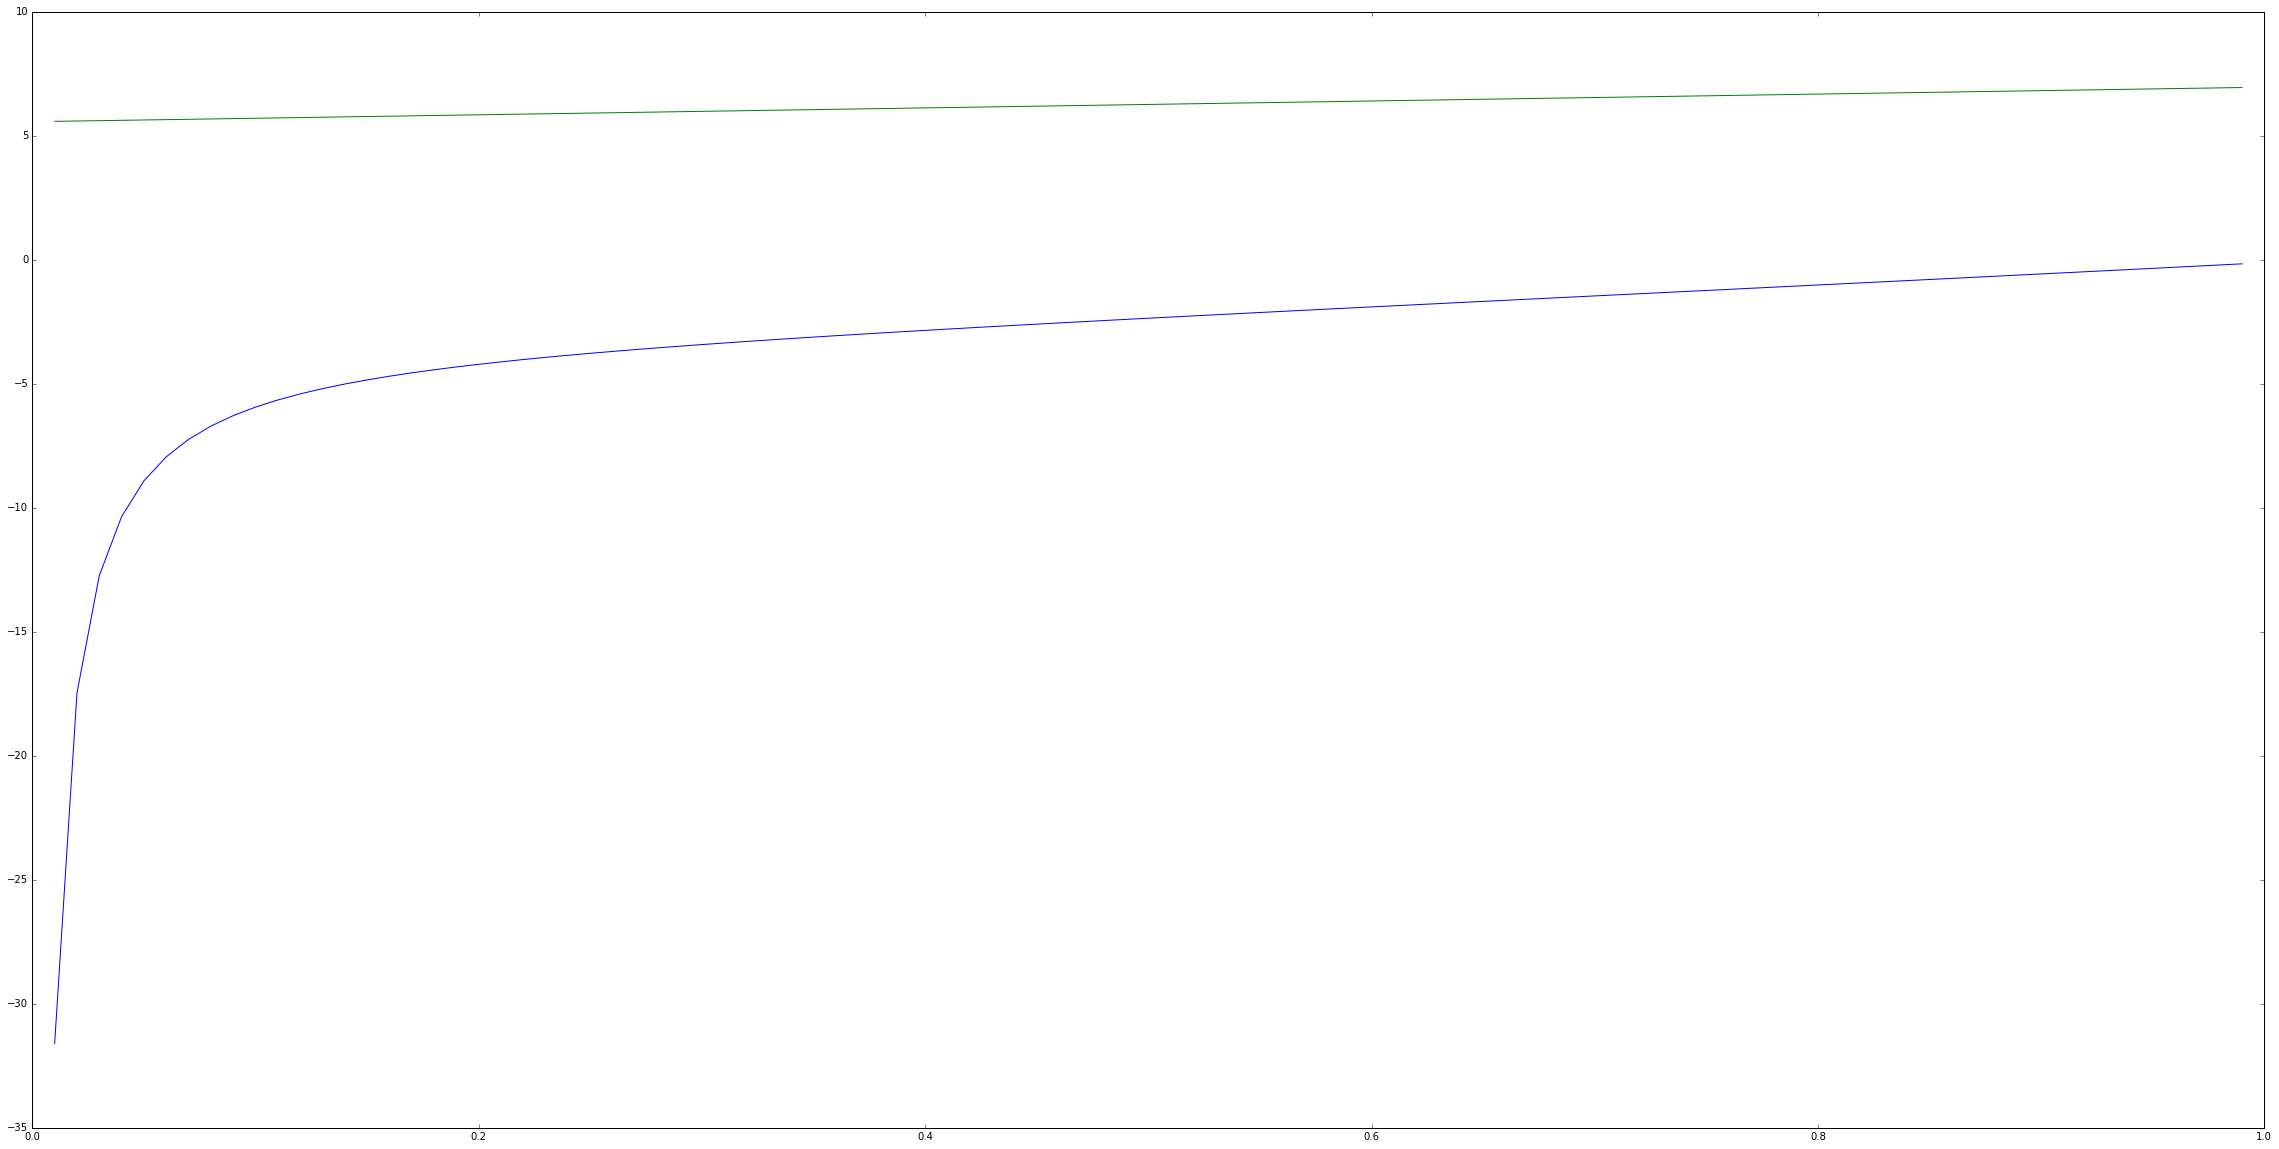

In [223]:
plt.figure(figsize=(40,20))
plt.plot(x[:99],zeta00[:99])
p_s = (1+x/4)
p_s*=np.pi**(3/2)
plt.plot(x[:99],p_s[:99])

In [224]:
for i in range(10):
    print(i,fact(i))

0 1
1 1
2 2
3 6
4 24
5 120
6 720
7 5040
8 40320
9 362880
